# Tâche 2 — Estimation de l'âge (Régression)

## 1. Introduction & Objectifs
- Objectif : prédire l’âge réel à partir d’une image.
- Données : `data/train` (>40k images `XXXXXX_YZWW`), `data/test` (200 images `0`→`199`).
- Livrables :
  - `results/age_estimation/age_predictions.csv` (colonnes `image_id,predicted_age`)
  - `models/age_estimation/age_estimation_best.pth`
  - Notebook complet (ce fichier)

## 2. Chargement des librairies & Configuration
- Import des librairies
- Lecture du fichier de config : `src/utils/config_t2.yaml`

In [21]:
# === Rendre src importable depuis notebooks/ ===
import os, sys
sys.path.insert(0, os.path.abspath(".."))

# === Config YAML ===
import yaml
with open("../src/utils/config_t2.yaml") as f:
    config = yaml.safe_load(f)

# === Imports modèle ===
from src.models import AgeEstimationNet

print("Configuration Tâche 2 chargée ✅")
print("AgeEstimationNet importé ✅")

Configuration Tâche 2 chargée ✅
AgeEstimationNet importé ✅


## 3. Exploration du dataset
- Extraction des métadonnées depuis les noms de fichiers (ID, sexe, âge)
- Analyse distributions (âge, sexe), exemples d’images

In [22]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class AgeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for fname in os.listdir(root_dir):
            if fname.lower().endswith(".jpg") or fname.lower().endswith(".png"):
                parts = fname.split("_")
                if len(parts) >= 2:
                    info = parts[1]  # Exemple: "0M25"
                    age_str = "".join([c for c in info if c.isdigit()])
                    if age_str.isdigit():
                        age = int(age_str)
                        self.samples.append((fname, age))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname, age = self.samples[idx]
        img_path = os.path.join(self.root_dir, fname)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, age


# Configuration DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_loader_t2 = DataLoader(
    AgeDataset("../data/tache2/train", transform=transform),
    batch_size=4,
    shuffle=True
)

test_loader_t2 = DataLoader(
    AgeDataset("../data/tache2/test", transform=transform),
    batch_size=4,
    shuffle=False
)


## 4. Split Train/Validation (anti-fuite)
- Détection/recadrage visage
- Normalisation 
- Split par **ID** (pas par image)
- Journaliser la proportion de chaque tranche d’âge

In [23]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms

# === Dataset ===
class AgeDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = str(row["image"])
        age = float(row["age"])
        img_path = os.path.join(self.root_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32)

# === Chemins depuis le notebook (../ remonte à la racine) ===
TRAIN_IMAGES = "../" + config["paths"]["train_dir"]   # ../data/tache2/train
VAL_IMAGES   = "../" + config["paths"]["train_dir"]   # validation puise aussi dans train/
TRAIN_LABELS = "../data/tache2/train_labels.csv"
VAL_LABELS   = "../data/tache2/val_labels.csv"

# === Transforms (rapide pour debug; passe à 224x224 pour entraînement final) ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === DataLoaders ===
train_loader_t2 = DataLoader(
    AgeDataset(TRAIN_LABELS, TRAIN_IMAGES, transform=transform),
    batch_size=config["training"]["batch_size"],
    shuffle=True,
    num_workers=0  # macOS: 0
)

val_loader_t2 = DataLoader(
    AgeDataset(VAL_LABELS, VAL_IMAGES, transform=transform),
    batch_size=config["training"]["batch_size"],
    shuffle=False,
    num_workers=0
)

# Test rapide
images, ages = next(iter(train_loader_t2))
print("Batch images:", images.shape, "| ages (extraits):", ages[:8])

Batch images: torch.Size([4, 3, 224, 224]) | ages (extraits): tensor([31., 36., 54., 38.])


## 5. Modèle
- Backbone moderne (type EfficientNet-like)
- Tête de régression (sortie : âge)
- Sauvegarde des poids dans `models/age_estimation/`

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import os, random
import numpy as np

# === Device ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Device utilisé : {device}")

# === Seed (reproductibilité) ===
seed = int(config["training"].get("seed", 42))
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

# === Modèle ===
model = AgeEstimationNet().to(device)

# === Perte + Optimizer ===
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"])

# === Fonctions ===
def train_one_epoch(loader, model, criterion, optimizer):
    model.train()
    running = 0.0
    for images, ages in loader:
        images = images.to(device)
        ages   = ages.to(device)

        optimizer.zero_grad()
        preds = model(images)           # [B]
        loss  = criterion(preds, ages)  # MSE
        loss.backward()
        optimizer.step()

        running += loss.item()
    return running / max(1, len(loader))

@torch.no_grad()
def evaluate(loader, model, criterion):
    model.eval()
    running = 0.0
    for images, ages in loader:
        images = images.to(device)
        ages   = ages.to(device)
        preds  = model(images)
        loss   = criterion(preds, ages)
        running += loss.item()
    return running / max(1, len(loader))

# === Dossier de sauvegarde ===
MODEL_DIR = os.path.join("..", config["paths"]["output_models"])
os.makedirs(MODEL_DIR, exist_ok=True)

best_val = float("inf")
num_epochs = int(config["training"]["epochs"])

for epoch in range(num_epochs):
    tr = train_one_epoch(train_loader_t2, model, criterion, optimizer)
    va = evaluate(val_loader_t2, model, criterion)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train MSE: {tr:.4f} | Val MSE: {va:.4f}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best.pth"))
        print("💾 ✅ Meilleur modèle sauvegardé !")

✅ Device utilisé : mps
[Epoch 1/1] Train MSE: 38.5305 | Val MSE: 39.6432
💾 ✅ Meilleur modèle sauvegardé !


## 6. Entraînement
- Perte principale : MAE (suivi RMSE)
- Journal des métriques par epoch

In [26]:
import os, torch, pandas as pd
from src.models.age_estimation_model import AgeEstimationNet  # adapte le chemin si besoin

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Charger le meilleur modèle
model = AgeEstimationNet().to(device)
model.load_state_dict(torch.load("../models/age_estimation/best.pth", map_location=device))
model.eval()

# Choisir un loader de validation
# -> si tu as val_loader_t2, on l’utilise; sinon on tombe sur test_loader_t2
loader = None
if 'val_loader_t2' in globals():
    loader = val_loader_t2
elif 'test_loader_t2' in globals():
    print("⚠️ val_loader_t2 introuvable → utilisation de test_loader_t2 pour la génération du CSV.")
    loader = test_loader_t2
else:
    raise RuntimeError("Aucun loader trouvé (val_loader_t2/test_loader_t2).")

# Inférence et enregistrement
rows = []
with torch.no_grad():
    for imgs, ages_true in loader:
        imgs = imgs.to(device)
        preds = model(imgs).view(-1).cpu().numpy()   # prédictions [B]
        ages_true = ages_true.numpy().astype(float)  # truths [B]
        for t, p in zip(ages_true, preds):
            rows.append({"age_true": float(t), "age_pred": float(p)})

out_dir = "../results/age_estimation"
os.makedirs(out_dir, exist_ok=True)
csv_path = os.path.join(out_dir, "val_predictions.csv")
pd.DataFrame(rows).to_csv(csv_path, index=False)
print("✅ CSV généré :", csv_path, "| lignes :", len(rows))


✅ CSV généré : ../results/age_estimation/val_predictions.csv | lignes : 4002


## 7. Évaluation (Validation)
- Métriques : MAE, RMSE
- Histogrammes des erreurs et par tranches d’âge

MAE : 4.97
RMSE: 6.30


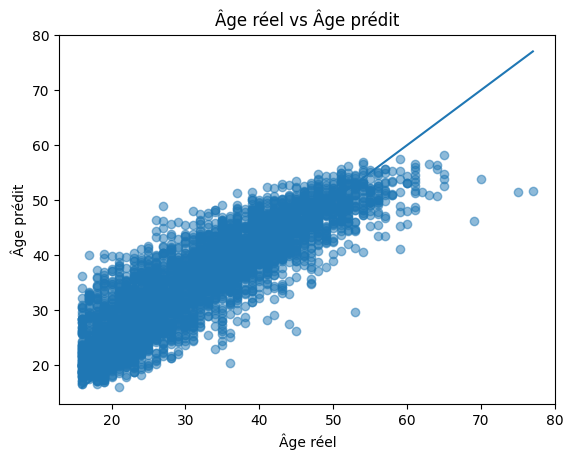

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Charger résultats val
val_csv = "../results/age_estimation/val_predictions.csv"
df = pd.read_csv(val_csv)

# Sécuriser les types (au cas où)
df["age_true"] = pd.to_numeric(df["age_true"], errors="coerce")
df["age_pred"] = pd.to_numeric(df["age_pred"], errors="coerce")
df = df.dropna(subset=["age_true", "age_pred"])

y_true = df["age_true"].values
y_pred = df["age_pred"].values

# Métriques
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Scatter plot
plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("Âge réel")
plt.ylabel("Âge prédit")
plt.title("Âge réel vs Âge prédit")
mn, mx = float(np.min(y_true)), float(np.max(y_true))
plt.plot([mn, mx], [mn, mx])   # diagonale (sans couleur imposée)
plt.show()

## 8. Inférence sur Test
- Générer `results/age_estimation/age_predictions.csv`
- Colonnes : `image_id,predicted_age`

In [25]:
import os
import torch
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as transforms

# === Chemins ===
TEST_DIR = os.path.join("..", config["paths"]["test_dir"])               # ex: ../data/tache2/test
OUT_DIR  = os.path.join("..", config["paths"]["output_results"])         # ex: ../results/age_estimation
WEIGHTS  = os.path.join("..", config["paths"]["output_models"], "best.pth")
os.makedirs(OUT_DIR, exist_ok=True)

# === Paramètres d'évaluation ===
age_min = int(config["evaluation"].get("age_range_min", 0))
age_max = int(config["evaluation"].get("age_range_max", 100))

# === Dataset test (image, filename) ===
class AgeTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = [f for f in os.listdir(root) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        self.files.sort()
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        fname = self.files[idx]
        img   = Image.open(os.path.join(self.root, fname)).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, fname

# === Transform identique à l'entraînement ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === Device & modèle ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = AgeEstimationNet().to(device)
assert os.path.isfile(WEIGHTS), f"Poids introuvables: {WEIGHTS}"
model.load_state_dict(torch.load(WEIGHTS, map_location=device))
model.eval()

# === Inférence ===
test_ds = AgeTestDataset(TEST_DIR, transform=transform)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

pred_rows = []
with torch.no_grad():
    for imgs, fnames in test_dl:
        imgs = imgs.to(device)
        preds = model(imgs).detach().cpu()  # valeurs réelles (float)
        # clamp + round (souvent demandé par les challenges âge)
        preds = preds.clamp(min=age_min, max=age_max).round().int().tolist()
        for fn, age in zip(fnames, preds):
            pred_rows.append((fn, int(age)))

# === Sauvegarde CSV (filename,predicted_age) ===
out_csv = os.path.join(OUT_DIR, "age_predictions.csv")
with open(out_csv, "w") as f:
    f.write("filename,predicted_age\n")
    for fn, age in pred_rows:
        f.write(f"{fn},{age}\n")

print(f"✅ Prédictions d'âge: {len(pred_rows)} images")
print(f"💾 Fichier écrit: {out_csv}")


✅ Prédictions d'âge: 200 images
💾 Fichier écrit: ../results/age_estimation/age_predictions.csv
